# Прогнозирование метрик. Задание 1

Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-07-14 по 2023-07-20. Ваша задача как аналитика – оценить эффективность этого мероприятия.

1. Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложите не менее 5 метрик.
2. Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.
3. Необязательно: имел ли флэшмоб какие-то долгосрочные эффекты? 

Сделайте выводы по полученным результатам.

Формат сдачи задания – merge request в GitLab с ноутбуком, где выполнены вычисления (формат .ipynb).

## Какие метрики должны были измениться во время флэшмоба и как? Почему? Предложите не менее 5 метрик.


Оценка эффективности флэшмоба в ленте новостей можно провести с помощью следующих метрик:

1. **Число уникальных пользователей по дням (DAU)**. Если число активных пользователей выросло (в том числе за счёт новых) во время мероприятия, то это хорошо для приложения. Следуюшие вопросы, связанные с этой метрикой: 
    * на сколько качественная новоприбывщая аудитория;
    * и на сколько рост обучловлен именно флешмобом. На дашборде [Новостная лента. Исторические данные](https://superset.lab.karpov.courses/superset/dashboard/4048/) наблюдается рост DAU, но как будто бы с той же скоростью, что и обычно.
2. **Retention rate** - эта метрика поможет сравнить уровень вовлеченности пользователей, пришедших во время флешмоба с ранее- или позжепришедшими пользователями и ответит на первый вопрос из п.1. Так, если посмотреть на дашборд [Retention](https://superset.lab.karpov.courses/superset/dashboard/4034/) на график `retention_organic_users`, то можно увидеть, что для когорт, пришедших в приложение 18...20 июля на 10 день Retention rate составляет `[57, 55, 63]` (%), а, например, пришедших в приложение 27...29 июля `[17, 18, 10]` (%). То есть можно предположить, что retention после флешмоба стал выше.
3. **Количество уникальных просмотренных публикаций в день**. Эта одна из мер активности пользователей. Был всплеск в даты флешмоба, а потом возвращение к прежним уровням. https://redash.lab.karpov.courses/queries/35097/source#71840
4. **Количество лайков**. Показатель вовлеченности аудитории. Чем больше лайков, тем более успешным можно считать флэшмоб. Повышение числа лайков будет означать, что участники флэшмоба заинтересованы в контенте и проявляют положительную реакцию на него. На дашборде [Новостная лента. Исторические данные](https://superset.lab.karpov.courses/superset/dashboard/4048/) на графике `События` наблюдается рост и последующий спад после окончания флешмоба.
5. **Количество просмотров**. Это позволит измерить широту распространения контента и уровень его активной поддержки. На дашборде [Новостная лента. Исторические данные](https://superset.lab.karpov.courses/superset/dashboard/4048/) на графике `События` наблюдается рост и последующий спад после окончания флешмоба.
7. **CTR** 
    * **Простой CTR по пользователям**. На дашборде [Новостная лента. Исторические данные](https://superset.lab.karpov.courses/superset/dashboard/4048/) на графике `CTR` на глаз отличий нет. 
    * **общегрупповой CTR за день**. Визуально отзличий невидно: https://redash.lab.karpov.courses/queries/35095/source#71830
    * **общегрупповой CTR за час**. Тут что-то есть: https://redash.lab.karpov.courses/queries/35108/source#71859 **надо проверить**.
8. **Медианное за день время, проведённое пользователями в ленте**. Тоже мера интереса / вовлеченности пользователей. Визуально не изменилось: https://redash.lab.karpov.courses/queries/35099/source#71837


## Проверьте, реально ли эти метрики изменились, используя CausalImpact
Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько 

In [1]:
import pandahouse
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
from causalimpact import CausalImpact

2023-08-07 14:49:44.818103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 14:49:44.915717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 14:49:44.917260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 14:49:46.356690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [3]:
%%time
# Флэшмоб проходил с 2023-07-14 по 2023-07-20
# Возьмём данные за 2 недели до флещмоба - с 2023-07-01

# посмотрим, как менялся общегрупповой почасовой CTR
q = """
SELECT
  toStartOfHour(time) as day_hour,
  countIf(user_id, action = 'like') as likes,
  countIf(user_id, action = 'view') as views,
  likes / views as ctr
FROM
  {db}.feed_actions
WHERE
  day_hour between '2023-07-01' and '2023-07-20'
GROUP BY
  day_hour
"""

df = pandahouse.read_clickhouse(q, connection=connection)

CPU times: user 33.6 ms, sys: 10.5 ms, total: 44.2 ms
Wall time: 259 ms


In [4]:
df

,day_hour,likes,views,ctr
0,2023-07-07 20:00:00,6848,30487,0.224620
1,2023-07-01 11:00:00,3863,18416,0.209763
2,2023-07-07 11:00:00,4759,20911,0.227584
3,2023-07-02 21:00:00,4492,21752,0.206510
4,2023-07-03 14:00:00,4051,18823,0.215215
...,...,...,...,...
452,2023-07-03 20:00:00,5642,28149,0.200433
453,2023-07-07 22:00:00,5806,26253,0.221156
454,2023-07-02 19:00:00,4722,22897,0.206228
455,2023-07-03 12:00:00,4141,19354,0.213961


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   day_hour  457 non-null    datetime64[ns]
 1   likes     457 non-null    uint64        
 2   views     457 non-null    uint64        
 3   ctr       457 non-null    float64       
dtypes: datetime64[ns](1), float64(1), uint64(2)
memory usage: 14.4 KB


In [6]:
df.set_index('day_hour', inplace=True)
df.sort_index(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 2023-07-01 00:00:00 to 2023-07-20 00:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   likes   457 non-null    uint64 
 1   views   457 non-null    uint64 
 2   ctr     457 non-null    float64
dtypes: float64(1), uint64(2)
memory usage: 14.3 KB


In [8]:
# Такое не сработало почему-то:
impact = CausalImpact(data=df['ctr'], #данные
                      pre_period=['2023-07-01', '2023-07-13'], #период до события
                      post_period=['2023-07-14', '2023-07-20']) #период после события

TypeError: unsupported operand type(s) for -: 'slice' and 'slice'

In [13]:
# ...и пришлось поступить так
df_ = df.reset_index()
df_[df_['day_hour'] < '2023-07-14']

,day_hour,likes,views,ctr
0,2023-07-01 00:00:00,3517,15597,0.225492
1,2023-07-01 01:00:00,2732,12983,0.210429
2,2023-07-01 02:00:00,2060,9500,0.216842
3,2023-07-01 03:00:00,1409,6751,0.208710
4,2023-07-01 04:00:00,1426,6819,0.209122
...,...,...,...,...
307,2023-07-13 19:00:00,7772,39371,0.197404
308,2023-07-13 20:00:00,7498,38065,0.196979
309,2023-07-13 21:00:00,7422,38082,0.194895
310,2023-07-13 22:00:00,6783,34663,0.195684


In [14]:
df_.shape[0] - 1

456

In [15]:
impact = CausalImpact(data=df_['ctr'], #данные
                      pre_period=[0, 311], #период до события
                      post_period=[312, 456]) #период после события

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-08-07 14:50:50.724496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-08-07 14:50:50.724894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-08-07 14:50:50.739158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-08-07 14:50:50.739528: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2023-08-07 14:50:51.932295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-07 14:50:51.964692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-07 14:50:52.015689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2023-08-07 14:51:57.877839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-08-07 14:51:57.988241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

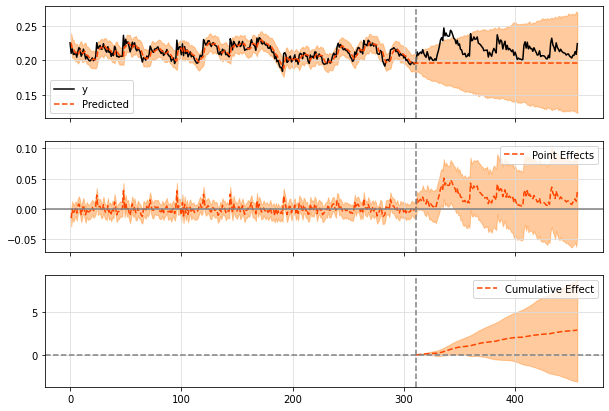

In [16]:
impact.plot()

# Вывод
**Вывод** Есть увеличение CTR во время флешмоба - кривая `Cumulative effect` идёт вверх

# Eщё

А если сравнить обычным t-test? Да, это неправильно сравнивать разные промежутки времени, но я всё равно посмотрю))

In [19]:
from scipy import stats
import seaborn as sns

In [24]:
# df['before_after']
df_['flashmob'] = df_.apply(lambda x: 'before' if x['day_hour'] <= pd.to_datetime('2023-07-13') else 'flashmob', axis='columns')

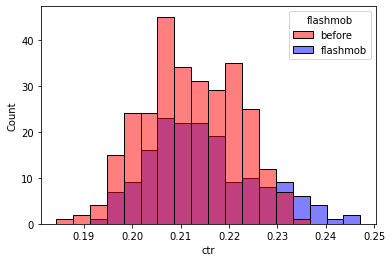

In [25]:
# Посмотрим распределения CTR в группах 1 и 2
groups = sns.histplot(
    data = df_, 
    x='ctr', 
    hue='flashmob', 
    palette = ['r', 'b'],
    alpha=0.5,
    kde=False)

In [31]:
df_.groupby(by='flashmob').agg({'ctr': 'mean'})

,ctr
flashmob,
before,0.212168
flashmob,0.214795


In [32]:
stats.ttest_ind(df_[df_['flashmob'] == 'before']['ctr'],
                df_[df_['flashmob'] == 'flashmob']['ctr'],
                equal_var=False)

Ttest_indResult(statistic=-2.5333474334921484, pvalue=0.011787642052034777)

Тут тоже видно, что CTR немного увеличлися